# Automatic Streaming Highlights

This Notebook contains my experiments and my custom implementation using the code from Zulko's Automatic Soccer Highlights [[1]](http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/) in order to use it for my gaming streamings and my new project **Automatic Gaming Tools** which is a subtask of **Automatic Video Uploader**. 

Similar to Zulko's implementation, I would like to make a video summary of a previously saved streaming video game, using the fact that myself and my friends (in the video that we recorded) usually scream, tend to be louder when something interesting happens. By this explained fact, in this project I select **as a metric for my gaming highlights the noisiness** of my clips in order for them to be put in the video. In other words, the loudest moments of the streaming will be the most considered to be put in the summary, which is also the same metric that is used in the Zulko's algorithm.

At the moment, I'm also working on another metrics for **Automatic Gaming/Streaming Highlights** based on specific in-game sounds that specify a possible highlight as a multikill, objective complete in Halo Infinite using **speech recognition** and the text recognition of the same events such as reading **DOUBLE KILL**, **OBJECTIVE COMPLETE** directly from the video input using **text recognition**. The repo for that project can be found [here](https://github.com/spolo96/gaming-text-speech-recognition).

With all of this said, let's get started.

In [1]:
import os
import matplotlib.pyplot as plt
import time
import numpy as np # for numerical operations
from moviepy.editor import VideoFileClip, concatenate, ipython_display

print(os.getcwd())

C:\Users\User\Documents\Python_Scripts\Automatic_Streaming_Highlights


Get the path of the videos that we would like to perform the automatic highlight:

In [3]:
os.chdir("M:\Videos\Automatic Highlights\Fall_Guys\Streaming2GottaGoFast") # Path of your videos directory
curDir = os.getcwd()
print(curDir)

M:\Videos\Automatic Highlights\Fall_Guys\Streaming2GottaGoFast


In [5]:
# Check videos in the path
!dir *mp4

 Volume in drive M is Volume
 Volume Serial Number is B2B6-D49C

 Directory of M:\Videos\Automatic Highlights\Fall_Guys\Streaming2GottaGoFast

30/03/2021  06:01 p.ÿm.     1.701.966.488 streaming2p1.mp4
30/03/2021  09:03 p.ÿm.       137.774.009 streaming2p1_cuts.mp4
30/03/2021  05:53 p.ÿm.     1.506.538.272 streaming2p2.mp4
31/03/2021  03:36 a.ÿm.       141.220.948 streaming2p2_80percent_cuts.mp4
31/03/2021  03:16 a.ÿm.       113.148.677 streaming2p2_cuts.mp4
30/03/2021  05:23 p.ÿm.       593.188.945 streaming2p3.mp4
               6 File(s)  4.193.837.339 bytes
               0 Dir(s)  804.769.955.840 bytes free


In [29]:
def showTimeGraph(x1,y1,title): 
    fig, ax = plt.subplots(figsize=(14,6)) # Create a figure and an axes.
    ax.plot(x1,y1) # Plot some data on the axes.

    ax.set(xlabel='Time (seconds)', ylabel='Volume',
        title=title)
    ax.grid()
    #ax.legend()  # Add a legend.
    
    fig.savefig("volumesPlot.png")
    plt.show()

The next lines open the video file with Python (which in my case is a Fall Guys 40min video downloaded from my Twitch recordings), compute the audio volume of each second of the video and finally it shows the time taken to do these steps.

In [7]:
start = time.time()

videoFileName = "streaming2p3.mp4" # Put here the name of the video you wish to make the automatic highlights.

clip = VideoFileClip(videoFileName)
cut = lambda i: clip.audio.subclip(i,i+1).to_soundarray(fps=22000)
volume = lambda array: np.sqrt(((1.0*array)**2).mean())
volumes = [volume(cut(i)) for i in range(0,int(clip.duration-1))]

end = time.time()

# Time taken to perform operation
print(end - start)

14.074833631515503


Short test where I see the range of volumes from the 40 minute video and I add them to a list to visualize them.

In [8]:
print(len(volumes))

a_list = list(range(0, len(volumes)))

#print(a_list)

2410


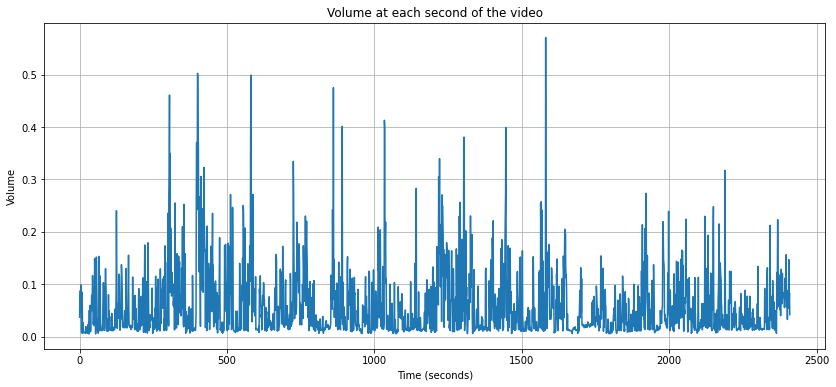

In [30]:
# If we plot the obtained volumes we can see that there are some moments where the noisiness gets very louder compared to
# the rest of the moments. These so loudest moments are the ones I'm very interested in, in order to put them automatically
# in the video summary or video highlights.
showTimeGraph(a_list, volumes, 'Volume at each second of the video')

In [10]:
# From [1]:
# It is much clearer if we compute the average volumes over periods of 10 seconds:
averaged_volumes = np.array([sum(volumes[i:i+10])/10 
                             for i in range(len(volumes)-10)])

In [11]:
# Same step as in the previous step to do some visualization.
a_list = list(range(0, len(volumes)-10))

In [12]:
print(len(a_list))

2400


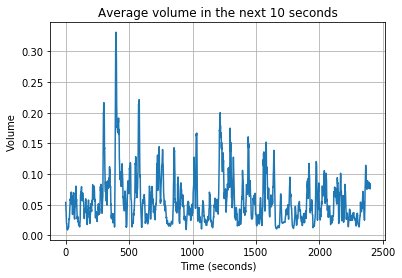

1

In [13]:
showTimeGraph(a_list, averaged_volumes, 'Average volume in the next 10 seconds')

Modified comments from [[1]](http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/):

As we can see in the above graph, there are some higher peaks that give us the loudest times of the recorded videogame, but other peaks may also indicate interesting events. In the next lines, we select the times of the 10% highest peaks:

In [14]:
increases = np.diff(averaged_volumes)[:-1]>=0
decreases = np.diff(averaged_volumes)[1:]<=0
peaks_times = (increases * decreases).nonzero()[0]
peaks_vols = averaged_volumes[peaks_times]
peaks_times = peaks_times[peaks_vols>np.percentile(peaks_vols,90)] # Can change the 90 to 80 or 70 to include more highlights.

From [[1]](http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/):

As a refinement, we regroup the times that are less than one minute apart, as they certainly correspond to the same event:

In [15]:
final_times=[peaks_times[0]]
for t in peaks_times:
    if (t - final_times[-1]) < 60:
        if averaged_volumes[t] > averaged_volumes[final_times[-1]]:
            final_times[-1] = t
    else:
        final_times.append(t)

In [16]:
print(final_times)

[302, 395, 578, 763, 853, 1031, 1217, 1295, 1438, 1580, 1640, 1974]


Modified comments from [[1]](http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/):

Now final_times contains the times (in seconds) of 12 events, from which we can cut our video. For each event we will start five seconds before its time and stop five seconds after. Then, we show the time taken to do all these steps :

In [17]:
start = time.time()
final = concatenate([clip.subclip(max(t-5,0),min(t+5, clip.duration))
                     for t in final_times])

highlightVideoName = 'streaming2p3_cuts.mp4'

final.to_videofile(highlightVideoName) # Low quality is the default
end = time.time()
print("Time of the algorithm: ")
print(end - start)

[MoviePy] >>>> Building video streaming2p3_cuts.mp4
[MoviePy] Writing audio in streaming2p3_cutsTEMP_MPY_wvf_snd.mp3


100%|██████████| 2646/2646 [00:03<00:00, 799.91it/s]

[MoviePy] Done.
[MoviePy] Writing video streaming2p3_cuts.mp4



100%|█████████▉| 3600/3601 [00:25<00:00, 139.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: streaming2p3_cuts.mp4 

Time of the algorithm: 
32.53192472457886


# Conclusions

This simple method works very well spotting gaming highlights using the **noisiness** metric in the volume of the video. A simple highlight video example that I created using this algorithm can be found here:
[Dragon Ball FighterZ example](https://www.youtube.com/watch?v=iJ1P0avtbDs&list=PLwAjkPGn41YWQlKNZ8maq5G9H5dCjKuPx) (The original video was 3 hours of content and the algorithm gave us a 10 minute video with all the highlights, saving us a lot of time checking the video again, finding all the possible highlight moments and putting them in a single video.)

As Zulko said in [1], (talking about the original video which was a soccer game): "The algorithm can be confused by broadcasters which make lots of replays or lower the sound of the crowd after goals, and it may miscut some goals on penalties, because the crowd starts whistling long before the shoot. So large-scale applications would require a less naive model." 

The algorithm can be confused in these situations, but the solution itself already saves us an intense amount of time finding the possible highlights of the game/video of interest. Since the loudest times can be selected in the **peaks_times** variable and the **final_times** variable contains the times (in seconds) of these events, we can manually check around the times in the array of **final_times** to find other possible highlights that the model couldn't find saving us a lot of time since we already know where to look at, instead of watching the whole video from start which could be very troublesome for very long videos as we can normally find in Twitch. 

# References

[[1] Automatic Soccer Highlights Compilations With Python](http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/)